In [1]:
using FMI, FMIFlux, FMIZoo
using FMIFlux.Flux
using OrdinaryDiffEq: Tsit5

In [2]:
import JLD2         # data format for saving/loading parameters

import Random       # for fixing the random seed
using Plots         # plotting results

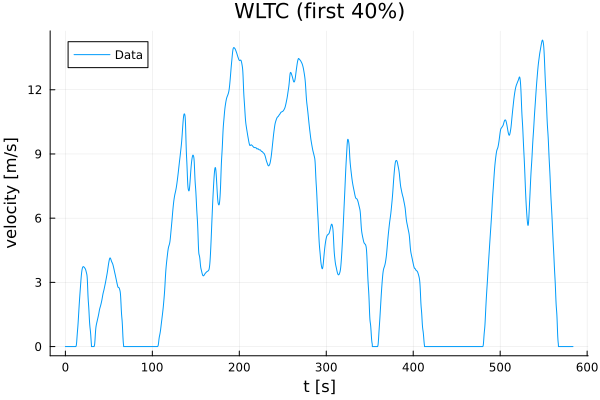

In [3]:
# FMIZoo.jl supports different data sampling rates (by interpolation), sample length for data is 0.1s
dt = 0.1 

# load data (training) from FMIZoo.jl
data = FMIZoo.VLDM(:train, dt=dt) 

# plot the velocity consumption (training data)
plot(data.speed_t,              # the time points the speed was captures (from data)
     data.speed_val;            # the speeds at the considered time points (from data)
     ribbon=data.speed_dev,     # a `ribbon` for the speed deviation - so the `uncertainty` because we made two measurements - but don't expect too much to see (very little uncertainty)
     fillalpha=0.3,             # alpha value for the ribbon
     label="Data",              # the plot label
     title="WLTC (first 40%)",  # plot title
     xlabel="t [s]",            # plot x-label
     ylabel="velocity [m/s]")   # plot y-label

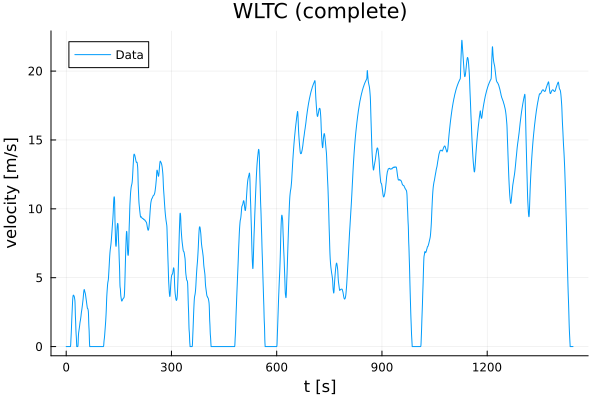

In [4]:
# load data (validation) from FMIZoo.jl
data_validation = FMIZoo.VLDM(:validate, dt=dt)

# plot the velocity consumption (validation data)
plot(data_validation.speed_t, data_validation.speed_val; label="Data", ribbon=data_validation.speed_dev, fillalpha=0.3, title="WLTC (complete)", xlabel="t [s]", ylabel="velocity [m/s]")

In [5]:
# start (`tStart`) and stop time (`tStop`) for simulation, saving time points for ODE solver (`tSave`)
tStart = data.consumption_t[1]
tStop = data.consumption_t[end]
tSave = data.consumption_t

5838-element Vector{Float64}:
   0.0
   0.1
   0.2
   0.3
   0.4
   0.5
   0.6
   0.7
   0.8
   0.9
   ⋮
 582.9
 583.0
 583.1
 583.2
 583.3
 583.4
 583.5
 583.6
 583.7

In [6]:
# get start state vector from data (FMIZoo)
x0 = FMIZoo.getStateVector(data,    # the data container
                           tStart)  # the point in time where we want the state

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [7]:
# have a look on the FMU parameters (these are the file paths to the characteristic maps, remaining parameters are set to default by the FMU)
display(data.params)

Dict{String, Any} with 3 entries:
  "peFileName" => "C:\\Users\\DELL User\\.julia\\packages\\FMIZoo\\WtBM9\\src\\…
  "edFileName" => "C:\\Users\\DELL User\\.julia\\packages\\FMIZoo\\WtBM9\\src\\…
  "dcFileName" => "C:\\Users\\DELL User\\.julia\\packages\\FMIZoo\\WtBM9\\src\\…

In [8]:
# load our FMU of the VLDM (we take it from the FMIZoo.jl, exported with Dymola 2020x)
fmu = loadFMU("VLDM", "Dymola", "2020x"; type=:ME) 

# let's have a look on the model meta data
info(fmu)

#################### Begin information for FMU ####################
	Model name:			Longitudinaldynamic.LongitudinaldynamicmodelContinuous
	FMI-Version:			2.0
	GUID:				{669889ab-7ab7-4fac-be92-96b6cd0b86a6}
	Generation tool:		Dymola Version 2020x (64-bit), 2019-10-10
	Generation time:		2022-07-22T09:32:50Z
	Var. naming conv.:		structured
	Event indicators:		28
	Inputs:				0
	Outputs:			0
	States:				6
		33554432 ["driver.accelerationPedalController.PI.x"]
		33554433 ["driver.brakePedalController.PI.x"]
		33554434 ["drivingCycle.s"]
		33554435 ["dynamics.accelerationCalculation.integrator.y"]
		33554436 ["dynamics.accelerationCalculation.limiter.u", "dynamics.accelerationCalculation.limIntegrator.y", "dynamics.accelerationCalculation.limiter.simplifiedExpr"]
		33554437 ["result.integrator.y"]
	Parameters:			102
		16777216 ["i_gear"]
		16777217 ["rho_L"]
		16777218 ["vehMass"]
		16777219 ["payload"]
		...
		16777303 ["dynamics.accelerationCalculation.limIntegrator.y_start"]
		16777304 ["

In [9]:
# let's run a simulation from `tStart` to `tStop`, use the parameters we just viewed for the simulation run
resultFMU = simulate(fmu,                       # the loaded FMU of the VLDM 
                    (tStart, tStop);            # the simulation time range
                    parameters=data.params,     # the parameters for the VLDM
                    showProgress=true,  # show (or don't) the progres bar
                    recordValues=:derivatives,  # record all state derivatives
                    saveat=tSave)               # save solution points at `tSave`
display(resultFMU)

Simulating ME-FMU ... 100%|██████████████████████████████| Time: 0:00:55


Model name:
	Longitudinaldynamic.LongitudinaldynamicmodelContinuous
Success:
	true
f(x)-Evaluations:
	In-place: 441149
	Out-of-place: 0
Jacobian-Evaluations:
	∂ẋ_∂p: 0
	∂ẋ_∂x: 0
	∂ẋ_∂u: 0
	∂y_∂p: 0
	∂y_∂x: 0
	∂y_∂u: 0
	∂e_∂p: 0
	∂e_∂x: 0
	∂e_∂u: 0
	∂xr_∂xl: 0
Gradient-Evaluations:
	∂ẋ_∂t: 0
	∂y_∂t: 0
	∂e_∂t: 0
Callback-Evaluations:
	Condition (event-indicators): 756903
	Time-Choice (event-instances): 58371
	Affect (event-handling): 58409
	Save values: 5838
	Steps completed: 62982
States [5838]:
	0.0	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	0.1	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 14.260000000955804]
	0.2	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 28.52000000095581]
	0.3	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 42.78000000095581]
	0.4	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036

┌ Info: fmiPlot(...): Number of time events (58370) exceeding 100, disabling automatic plotting of time events (can be forced with keyword `timeEvents=true`).
└ @ PlotsExt C:\Users\DELL User\.julia\packages\FMIBase\kd0aT\ext\PlotsExt.jl:116


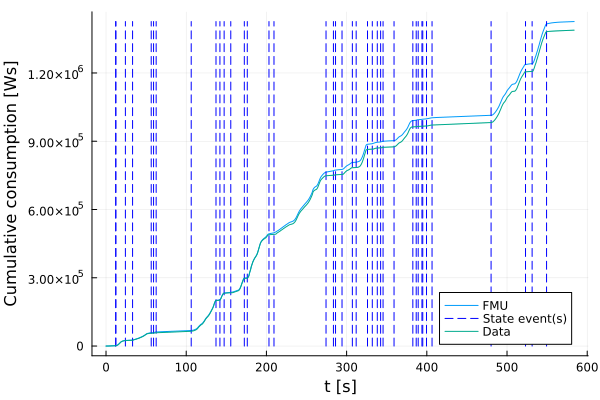

In [19]:
# Plot the simulation results
fig = plot(resultFMU;                               # the simulation result from above 
           values=false,                            # don't plot values (:derivatives)
           stateIndices=6:6,                        # only plot states 6 to 6 -> so state 6 ;-)
           ylabel="Cumulative consumption [Ws]",    # set the title for the y-label
           label="FMU")                             # title the plot line 

# further plot the (measurement) data values `consumption_val` and deviation between measurements `consumption_dev`
plot!(fig, data.cumconsumption_t, data.cumconsumption_val; label="Data", ribbon=data.cumconsumption_dev, fillalpha=0.3)

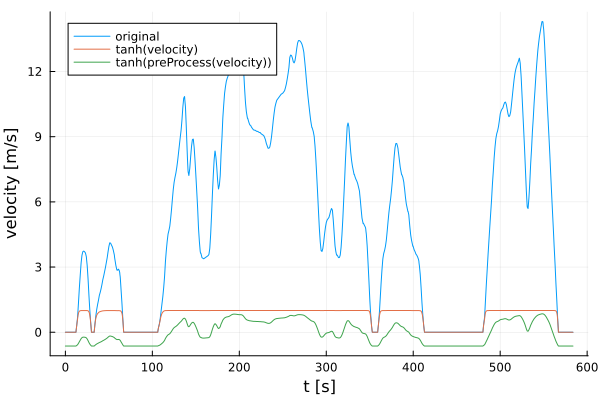

In [29]:
# variable we want to manipulate - why we are picking exactly these three is shown a few lines later ;-)
manipulatedDerVars = ["der(dynamics.accelerationCalculation.integrator.y)",
                      "der(dynamics.accelerationCalculation.limIntegrator.y)",
                      "der(result.integrator.y)"]
manipulatedDerVals = getValue(resultFMU, manipulatedDerVars)

# what happens without proper transformation between FMU- and ANN-domain?
plot(resultFMU.values.t, manipulatedDerVals[1,:][1]; label="original", xlabel="t [s]", ylabel="velocity [m/s]")
plot!(resultFMU.values.t, tanh.(manipulatedDerVals[1,:][1]); label="tanh(velocity)")

# pre- and post-processin
preProcess = ShiftScale(manipulatedDerVals);    # we put in the derivatives recorded above, FMIFlux shift and scales so we have a data mean of 0 and a standard deivation of 1 (other activation functions / ranges are possible!)
testVals = collect(tanh(preProcess(collect(val[t] for val in manipulatedDerVals))[1]) for t in 1:length(resultFMU.values.t))
plot!(resultFMU.values.t, 
      testVals; 
      label="tanh(preProcess(velocity))")

In [31]:
# function that builds the considered NeuralFMU on basis of a given FMU (FMI-Version 2.0) `f`
function build_NFMU(f::FMU2)
    
    # pre- and post-processing
    preProcess = ShiftScale(manipulatedDerVals)         # we put in the derivatives recorded above, FMIFlux shift and scales so we have a data mean of 0 and a standard deviation of 1
    preProcess.scale[:] *= 0.25                         # add some additional "buffer"
    postProcess = ScaleShift(preProcess; indices=2:3)   # initialize the postProcess as inverse of the preProcess, but only take indices 2 and 3 (we don't need 1, the vehicle velocity)

    # cache
    cache = CacheLayer()                        # allocate a cache layer
    cacheRetrieve = CacheRetrieveLayer(cache)   # allocate a cache retrieve layer, link it to the cache layer

    # we have two signals (acceleration, consumption) and two sources (ANN, FMU), so four gates:
    # (1) acceleration from FMU (gate=1.0 | open)
    # (2) consumption  from FMU (gate=1.0 | open)
    # (3) acceleration from ANN (gate=0.0 | closed)
    # (4) consumption  from ANN (gate=0.0 | closed)
    # the accelerations [1,3] and consumptions [2,4] are paired
    gates = ScaleSum([1.0, 1.0, 0.0, 0.0], [[1,3], [2,4]]) # gates with sum

    # setup the NeuralFMU topology
    model = Chain(x -> f(; x=x, dx_refs=:all),        # take `x`, put it into the FMU, retrieve all derivatives `dx`
                  dx -> cache(dx),                    # cache `dx`
                  dx -> dx[4:6],                      # forward only dx[4, 5, 6]
                  preProcess,                         # pre-process `dx`
                  Dense(3, 32, tanh),                 # Dense Layer 3 -> 32 with `tanh` activation
                  Dense(32, 2, tanh),                 # Dense Layer 32 -> 2 with `tanh` activation 
                  postProcess,                        # post process `dx`
                  dx -> cacheRetrieve(5:6, dx),       # dynamics FMU | dynamics ANN
                  gates,                              # compute resulting dx from ANN + FMU
                  dx -> cacheRetrieve(1:4, dx))       # stack together: dx[1,2,3,4] from cache + dx[5,6] from gates

    solver = Tsit5()
    
    # new NeuralFMU 
    neuralFMU = ME_NeuralFMU(f,                 # the FMU used in the NeuralFMU 
                             model,             # the model we specified above 
                             (tStart, tStop),   # a default start ad stop time for solving the NeuralFMU
                             solver;
                             saveat=tSave)      # the time points to save the solution at
    neuralFMU.modifiedState = false             # speed optimization (NeuralFMU state equals FMU state)
    
    return neuralFMU 
end

build_NFMU (generic function with 1 method)

In [32]:
# build NeuralFMU
neuralFMU = build_NFMU(fmu);

In [34]:
# simulate and plot the (uninitialized) NeuralFMU
resultNFMU = neuralFMU(x0,                          # the start state to solve the ODE
                       (tStart, tStop);             # the simulation range
                       parameters=data.params,      # the parameters for the VLDM
                       showProgress=true,   # show progress (or not)
                       saveat=tSave)                # the time points to save the solution at

display(resultNFMU)     

t=5.8368e+02s | Δt=1.0000e-02s | STPs=58438 | EVTs=58407 |  99%  ETA: 0:00:00

Model name:
	Longitudinaldynamic.LongitudinaldynamicmodelContinuous
Success:
	true
f(x)-Evaluations:
	In-place: 409926
	Out-of-place: 0
Jacobian-Evaluations:
	∂ẋ_∂p: 0
	∂ẋ_∂x: 0
	∂ẋ_∂u: 0
	∂y_∂p: 0
	∂y_∂x: 0
	∂y_∂u: 0
	∂e_∂p: 0
	∂e_∂x: 0
	∂e_∂u: 0
	∂xr_∂xl: 0
Gradient-Evaluations:
	∂ẋ_∂t: 0
	∂y_∂t: 0
	∂e_∂t: 0
Callback-Evaluations:
	Condition (event-indicators): 702407
	Time-Choice (event-instances): 58371
	Affect (event-handling): 58409
	Save values: 0
	Steps completed: 58440
States [5838]:
	0.0	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	0.1	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 14.260000000955804]
	0.2	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 28.52000000095581]
	0.3	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 42.78000000095581]
	0.4	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-1

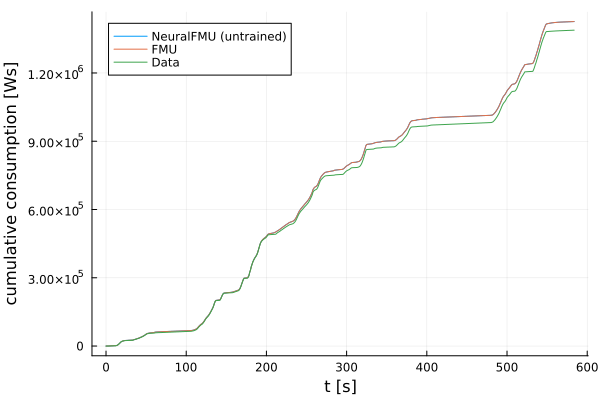

In [35]:
# plot the NeuralFMU, original FMU and data (cumulative consumption)
fig = plot(resultNFMU; stateIndices=6:6, stateEvents=false, timeEvents=false, label="NeuralFMU (untrained)", ylabel="cumulative consumption [Ws]")
plot!(fig, resultFMU; stateIndices=6:6, values=false, stateEvents=false, timeEvents=false, label="FMU")
plot!(fig, data.cumconsumption_t, data.cumconsumption_val, label="Data")

In [36]:
# unload FMU / invalidate NeuralFMU
unloadFMU(fmu)
neuralFMU = nothing

In [37]:
# prepare training data 
train_t = data.consumption_t 

# data is as "array of arrays" required (often we have multidimensional data)
train_data = collect([d] for d in data.cumconsumption_val)

5838-element Vector{Vector{Float64}}:
 [0.0]
 [-0.41296068176650935]
 [0.26787411983582043]
 [0.7202168791949798]
 [1.0714482470335085]
 [1.390037422822217]
 [2.1200151652794643]
 [2.5196535613914306]
 [2.656369007464336]
 [2.993187294279602]
 ⋮
 [1.3879825294049252e6]
 [1.3879980607748663e6]
 [1.3880134565080018e6]
 [1.3880287579379592e6]
 [1.388044098663902e6]
 [1.388059371012591e6]
 [1.388074504338062e6]
 [1.3880896849414955e6]
 [1.3881049434185931e6]

In [40]:
function _lossFct(solution::FMUSolution, data, LOSS::Symbol, LASTWEIGHT::Real=1.0/length(data.consumption_t) )

    # determine the start/end indices `ts` and `te` in the data array (sampled with 10Hz)
    ts = dataIndexForTime(solution.states.t[1])
    te = dataIndexForTime(solution.states.t[end])
    
    # retrieve the data from NeuralODE ("where we are") and data from measurements ("where we want to be") and an allowed deviation ("we are unsure about")
    nfmu_cumconsumption = getState(solution, 6; isIndex=true)
    cumconsumption = data.cumconsumption_val[ts:te]
    cumconsumption_dev = data.cumconsumption_dev[ts:te]

    Δcumconsumption = 0.0
    if LOSS == :MAE
        Δcumconsumption = FMIFlux.Losses.mae_last_element_rel_dev(nfmu_cumconsumption,  # NeuralFMU 
                                                                  cumconsumption,       # data target
                                                                  cumconsumption_dev,   # data uncertainty
                                                                  LASTWEIGHT)           # how much do we scale the last point compared to the remaining ones?
    elseif LOSS == :MSE
        Δcumconsumption = FMIFlux.Losses.mse_last_element_rel_dev(nfmu_cumconsumption, 
                                                                  cumconsumption, 
                                                                  cumconsumption_dev, 
                                                                  LASTWEIGHT)
    else
        @assert false, "Unknown LOSS: `$(LOSS)`"
    end
    
    return Δcumconsumption 
end

_lossFct (generic function with 2 methods)

In [53]:
# resource = training time horizon (duration of data seen)
function train!(hyper_params, resource, ind)

    # make the runs deterministic by fixing the random seed
    Random.seed!(1234)

    # training duration (in seconds) equals the given resource
    TRAINDUR = resource

    # unpack the hyperparameters
    ETA, BETA1, BETA2, BATCHDUR, LASTWEIGHT, SCHEDULER, LOSS = hyper_params

    # compute the number of training steps TRAINDUR / BATCHDUR, but do at least one step
    steps = max(round(Int, TRAINDUR/BATCHDUR), 1) 

    # print a bit of info
    @info "--------------\nStarting run $(ind) with parameters: $(hyper_params) and resource $(resource) doing $(steps) step(s).\n--------------------"

    # load our FMU (we take one from the FMIZoo.jl, exported with Dymola 2020x)
    fmu = loadFMU("VLDM", "Dymola", "2020x"; type=:ME) 

    # built the NeuralFMU on basis of the loaded FMU `fmu`
    neuralFMU = build_NFMU(fmu)

    # a more efficient execution mode
    FMI.singleInstanceMode(fmu, true)
    
    # batch the data (time, targets), train only on model output index 6, plot batch elements
    batch = batchDataSolution(neuralFMU,                            # our NeuralFMU model
                              t -> FMIZoo.getStateVector(data, t),  # a function returning a start state for a given time point `t`, to determine start states for batch elements
                              train_t,                              # data time points
                              train_data;                           # data cumulative consumption 
                              batchDuration=BATCHDUR,               # duration of one batch element
                              indicesModel=6:6,                     # model indices to train on (6 equals the state `cumulative consumption`)
                              plot=false,                           # don't show intermediate plots (try this outside of Jupyter)
                              parameters=data.params,               # use the parameters (map file paths) from *FMIZoo.jl*
                              showProgress=true)            # show or don't show progress bar, as specified at the very beginning

    # limit the maximum number of solver steps to 1000 * BATCHDUR (longer batch elements get more steps)
    # this allows the NeuralFMU to do 10x more steps (average) than the original FMU, but more should not be tolerated (to stiff system)
    solverKwargsTrain = Dict{Symbol, Any}(:maxiters => round(Int, 1000*BATCHDUR)) 
    
    # a smaller dispatch for our custom loss function, only taking the solution object
    lossFct = (solution::FMUSolution) -> _lossFct(solution, data, LOSS, LASTWEIGHT)

    # selecting a scheduler for training
    scheduler = nothing
    if SCHEDULER == :Random
        # a scheduler that picks a random batch element
        scheduler = RandomScheduler(neuralFMU, batch; applyStep=1, plotStep=0)
    elseif SCHEDULER == :Sequential
        # a scheduler that picks one batch element after another (in chronological order)
        scheduler = SequentialScheduler(neuralFMU, batch; applyStep=1, plotStep=0)
    elseif SCHEDULER == :LossAccumulation
        # a scheduler that picks the element with largest accumulated loss:
        # - after every training step, the accumulated loss for every batch element is increased by the current loss value 
        # - when picking a batch element, the accumulated loss is reset to zero
        # - this promotes selecting elements with larger losses more often, but also prevents starving of elements with small losses
        scheduler = LossAccumulationScheduler(neuralFMU, batch, lossFct; applyStep=1, plotStep=0, updateStep=1)
    else 
        @error "Unknown SCHEDULER: ´$(SCHEDULER)´."
        return nothing
    end

    # loss for training, do a simulation run on a batch element taken from the scheduler
    loss = p -> FMIFlux.Losses.loss(neuralFMU,                          # the NeuralFMU to simulate
                                    batch;                              # the batch to take an element from
                                    p=p,                                # the NeuralFMU training parameters (given as input)
                                    parameters=data.params,             # the FMU parameters
                                    lossFct=lossFct,                    # our custom loss function
                                    batchIndex=scheduler.elementIndex,  # the index of the batch element to take, determined by the chosen scheduler
                                    logLoss=true,                       # log losses after every evaluation
                                    showProgress=true,          # show progress bar (or don't)
                                    solverKwargsTrain...)               # the solver kwargs defined above

    # gather the parameters from the NeuralFMU
    params = FMIFlux.params(neuralFMU)

    # initialize the scheduler, keywords are passed to the NeuralFMU
    FMIFlux.initialize!(scheduler; parameters=data.params, p=params[1], showProgress=true)
    
    # initialize Adam optimizer with our hyperparameters
    optim = Adam(ETA, (BETA1, BETA2))
   
    # the actual training
    FMIFlux.train!(loss,                            # the loss function for training
                   neuralFMU,                       # the neural FMU including the parameters to train
                   Iterators.repeated((), steps),   # an iterator repeating `steps` times
                   optim;                           # the optimizer to train
                   gradient=:ReverseDiff,           # ForwardDiff leads to good results for multi-event systems
                   chunk_size=32,                   # ForwardDiff chunk_size (=number of parameter estimations per run) - only if ForwardDiff is used
                   cb=() -> FMIFlux.update!(scheduler),     # update the scheduler after every step 
                   proceed_on_assert=true)          # proceed, even if assertions are thrown, with the next step
    
    # the default execution mode
    FMI.singleInstanceMode(fmu, false)

    # save our result parameters
    FMIFlux.saveParameters(neuralFMU, joinpath(@__DIR__, "params", "$(ind).jld2"))
    
    # simulate the NeuralFMU on a validation trajectory
    resultNFMU = neuralFMU(x0, (data_validation.consumption_t[1], data_validation.consumption_t[end]); parameters=data_validation.params, showProgress=true, maxiters=1e7, saveat=data_validation.consumption_t)

    # determine loss on validation data (if the simulation was successful)
    validation_loss = nothing 
    if resultNFMU.success
        # compute the loss on VALIDATION data 
        validation_loss = _lossFct(resultNFMU,      # the NeuralFMU
                                  data_validation,  # the validation data set 
                                  :MSE)             # use MSE 
    end        

    # unload FMU
    unloadFMU(fmu)

    # return the loss (or `nothing` if no loss can be determined)
    return validation_loss
end

train! (generic function with 1 method)

In [54]:
# check if the train function is working for a set of given (random) hyperparameters
#     ([  ETA, BETA1,  BETA2, BATCHDUR, LASTWEIGHT, SCHEDULER, LOSS], RESOURCE, INDEX)
train!([0.0001,  0.9,  0.999,      4.0,        0.7,   :Random, :MSE],      8.0,     1)

┌ Info: --------------
│ Starting run 1 with parameters: Any[0.0001, 0.9, 0.999, 4.0, 0.7, :Random, :MSE] and resource 8.0 doing 2 step(s).
│ --------------------
└ @ Main c:\Users\DELL User\Desktop\torchdeeponet\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X33sZmlsZQ==.jl:17


AssertionError: AssertionError: ["No FMU instance allocated (in current thread with ID `1`), have you already called `fmiXInstantiate!`?"]